
Copyright 2019-2022 Universidad Complutense de Madrid

This file software has been employed to reduce infrared 
raw data from the CIRCE camera at GTC (see [Cabello et al. 2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...659A.116C/abstract))

Authors: Cristina Cabello (criscabe@ucm.es), 
         Nicolás Cardiel (cardiel@ucm.es)
         Jesús Gallego (j.gallego@ucm.es)

SPDX-License-Identifier: GPL-3.0+
License-Filename: LICENSE.txt


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
mpl.rcParams['font.size'] = 17.0
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 2


from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
import numpy as np
import pandas as pd

from numina.array.display.ximshow import jimshow
from numina.array.stats import robust_std

from astropy.coordinates import SkyCoord


## <span style="color:red">  ASTROMETRIC CALIBRATION OF THE NB1257 IMAGE </span>




The final solution was obtained by making use of the traditional wcstools (http://tdc-www.harvard.edu/wcstools/). 

### Installation of wcstools (under Mac OS X Big Sur)

I have downloaded `wcstools-3.9.6.tar.gz`. 

```
$ tar zxvf wcstools-3.9.6.ta.gz
$ cd wcstools-3.9.6
```

It is necessary to modify the second line in `libwcs/Makefile`, changing:
```
CC= cc
```
by
```
CC= gcc-mp-10 -I/Library/Developer/CommandLineTools/SDKs/MacOSX10.14.sdk/usr/include -L/Library/Developer/CommandLineTools/SDKs/MacOSX10.14.sdk/usr/lib
```

Before compiling the code, it is useful to double check that the command line tools are installed:

```
$ xcode-select --install
```

After this process, we can proceed with the installation:

```
$ make
```

## Generating the WCS solution

We need a file with 4 columns: X, Y, RA and DEC. This file is called `coords.txt`.

We selected the objects that present an HST counterpart, and we derived their positions (X,Y) in pixels using the function ‘extract’ of the SEP code in our final NB1257. These positions were used on the HST/F125W image to identify the sources and get the celestial coordinates (RA, DEC) from the 3D-HST catalog.

The initial FITS file without WCS calibration is called `CIRCE_image.fits`.

The program that computes the WCS solution is called `imwcs`:

```
$ ../wcstools-3.9.6/bin/imwcs -v CIRCE_image.fits -u coords.txt -o CIRCE_image_wcs_ini.fits
CIRCE_image.fits:
imwcs IMWCS WCSTools 3.9.6, 31 August 2020, Jessica Mink (jmink@cfa.harvard.edu)
Set World Coordinate System in FITS image file CIRCE_image.fits
ReadMatch: 0: 1249.040  411.720 14:19:39.456 +52:52:33.58
ReadMatch: 1: 1241.210 1474.560 14:19:39.543 +52:54:19.89
ReadMatch: 2: 1214.060  235.290 14:19:39.836 +52:52:15.72
ReadMatch: 3: 1061.630   78.680 14:19:41.514 +52:51:59.90
ReadMatch: 4: 1001.210 1435.170 14:19:42.191 +52:54:15.76
...
cra=  214.936  cdec =   52.885 xref= 789.921 yref= 737.907
scale = 2.78163e-05 deg/pix = 0.100139 arcsec/pix
Reference pixel (789.92,737.91) 14:19:53.278 +52:51:52.18 J2000
Search at 14:19:44.706 +52:53:09.82 J2000 +- 00:00:08.580 +00:01:17.64
Image width=1550 height=1550, 0 arcsec/pixel
CTYPE1 = RA---TAN
CRVAL1 = 214.93561143
CRPIX1 = 789.92100000
CTYPE2 = DEC--TAN
CRVAL2 = 52.88501505
CRPIX2 = 737.90700000
CD1_1 = -2.782e-05
CD1_2 = 0
CD2_1 = 0
CD2_2 = 2.782e-05
CIRCE_image_wcs_ini.fits: written successfully.
```



The header of the new image `CIRCE_image_wcs_ini.fits` is:

```
$ fitsheader CIRCE_image_wcs_ini.fits 
# HDU 0 in CIRCE_image_wcs_ini.fits:
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1550 / length of data axis 1                          
NAXIS2  =                 1550 / length of data axis 2                          
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CRVAL1  =        214.935611430                                                  
CRVAL2  =         52.885015050                                                  
WRA     = '14:19:44.547'                                                        
WDEC    = '+52:53:06.05'                                                        
EPOCH   =                 2000                                                  
WEQUINOX=                 2000                                                  
RADECSYS= 'FK5     '                                                            
CRPIX1  =             789.9210                                                  
CRPIX2  =             737.9070                                                  
SECPIX  =             0.100152                                                  
CDELT1  =      -0.000027820000                                                  
CDELT2  =       0.000027820000                                                  
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CD1_1   =      -0.000027820000                                                  
CD1_2   =       0.000000000000                                                  
CD2_1   =       0.000000000000                                                  
CD2_2   =       0.000027820000                                                  
RA      = '14:19:44.547'                                                        
DEC     = '+52:53:06.05'                                                        
EQUINOX =                 2000                                                  
CROTA1  =             0.000000                                                  
CROTA2  =             0.000000                                                  
IMWCS   = 'IMWCS WCSTools 3.9.6, 31 August 2020, Jessica Mink (jmink@cfa.harva'
```


## Use Python to double check the WCS solution

Read the `coords.txt` file

In [2]:
df = pd.read_csv('coords.txt', sep=',', comment='#', header=None)
df.columns = ['X', 'Y', 'RA', 'DEC']
df.head()

,X,Y,RA,DEC
0,1249.04,411.72,214.914398,52.875996
1,1241.21,1474.56,214.914764,52.905525
2,1214.06,235.29,214.915985,52.871033
3,1061.63,78.68,214.922974,52.866638
4,1001.21,1435.17,214.925797,52.904377


In [3]:
nrows = len(df)
print(f'Number of rows: {nrows}')

Number of rows: 14


In [4]:
circe_filename = 'CIRCE_image_wcs_ini.fits'

with fits.open(circe_filename) as hdul:
    header = hdul[0].header
    image2d = hdul[0].data

header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1550 / length of data axis 1                          
NAXIS2  =                 1550 / length of data axis 2                          
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CRVAL1  =        214.935611430                                                  
CRVAL2  =         52.885015050                                                  
WRA     = '14:19:44.547'                                                        
WDEC    = '+52:53:06.05'                                                        
EPOCH   =                 2000                                                  
WEQUINOX=                 20

Generate WCS object from the image header:

In [5]:
w = WCS(header)
print(w)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 214.93561143  52.88501505  
CRPIX : 789.921  737.907  
CD1_1 CD1_2  : -2.782e-05  0.0  
CD2_1 CD2_2  : 0.0  2.782e-05  
NAXIS : 1550  1550


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Fix previous warning by renaming the keyword:

In [6]:
header.rename_keyword('RADECSYS', 'RADESYSa')
w = WCS(header)
print(w)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 214.93561143  52.88501505  
CRPIX : 789.921  737.907  
CD1_1 CD1_2  : -2.782e-05  0.0  
CD2_1 CD2_2  : 0.0  2.782e-05  
NAXIS : 1550  1550


Save FITS file with corrected header keyword

In [7]:
hdu = fits.PrimaryHDU(image2d, header=header)
hdu.writeto('CIRCE_image_wcs.fits', overwrite=True)

## Compare initial (X,Y) coordinates with predicted (X,Y) values

Obtain the pixel scale in the X and Y directions

In [8]:
pixel_scales_arcsec_pix = proj_plane_pixel_scales(w)*3600
print(f'{pixel_scales_arcsec_pix} arcsec/pix in X and Y directions')

[0.100152 0.100152] arcsec/pix in X and Y directions


Convert RA and DEC to pixels using the WCS transformation

In [9]:
xpredicted, ypredicted = w.all_world2pix(df['RA'].values, df['DEC'].values, 1)

Compare the initial (X,Y) coordinates with the predicted ones

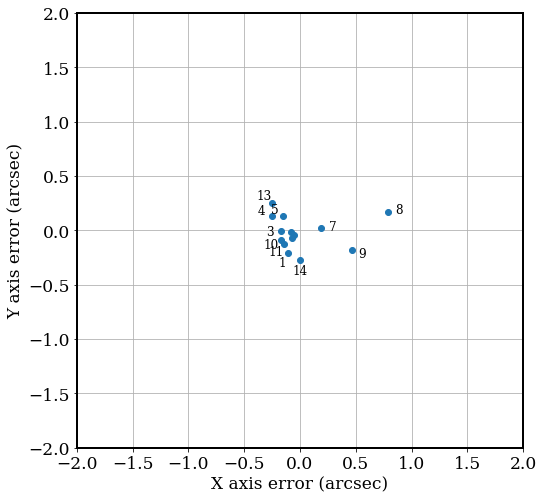

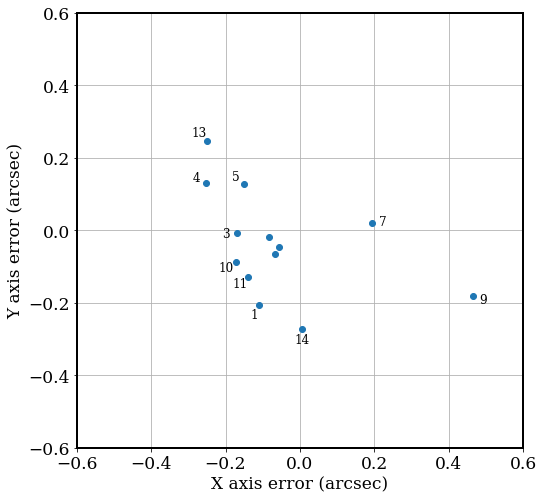

In [10]:
xerr_arcsec = (df['X'].values - xpredicted) * pixel_scales_arcsec_pix[0]
yerr_arcsec = (df['Y'].values - ypredicted) * pixel_scales_arcsec_pix[1]

for window in [2, 0.6]:

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 8))
    ax.plot(xerr_arcsec, yerr_arcsec, 'o')

    for idum, xdum, ydum in zip(range(nrows), xerr_arcsec, yerr_arcsec):
        if (abs(xdum) <= window) and (abs(ydum) <= window):
            r = np.sqrt(xdum**2 + ydum**2)
            if r > 0.1:
                theta = np.arctan2(ydum, xdum)
                xp = (r+window/20) * np.cos(theta)
                yp = (r+window/20) * np.sin(theta)
                ax.text(xp, yp, str(idum+1), fontsize=12, ha='center', va='center')

    ax.set_xlim([-window, window])
    ax.set_ylim([-window, window])
    ax.set_xlabel('X axis error (arcsec)')
    ax.set_ylabel('Y axis error (arcsec)')
    ax.grid()

In [11]:
print('Robust standard deviation in X: {:.3f} arcsec'.format(robust_std(xerr_arcsec)))
print('Robust standard deviation in Y: {:.3f} arcsec'.format(robust_std(yerr_arcsec)))

Robust standard deviation in X: 0.115 arcsec
Robust standard deviation in Y: 0.162 arcsec


Comparison between the initial (X,Y) coordinates (blue circle) and the predicted (X,Y) values (green cross) for the objects employed in the astrometric calibration

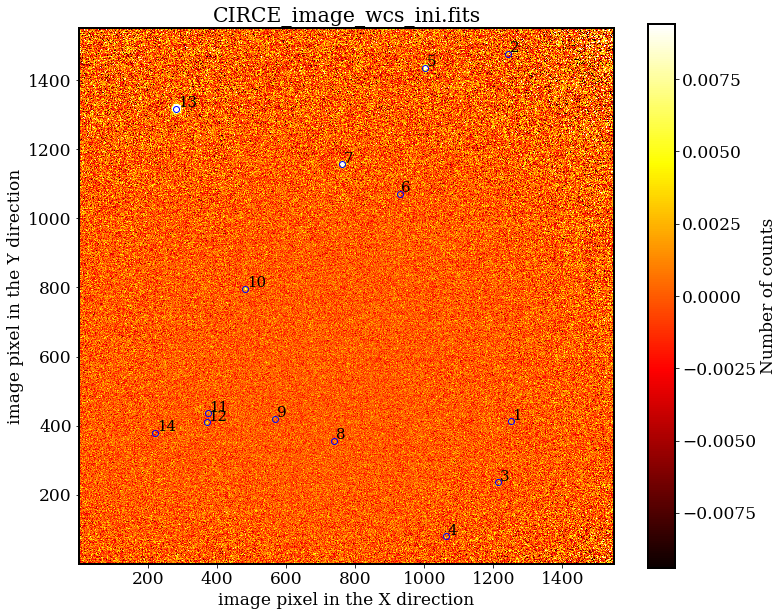

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 10))

jimshow(
    image2d=image2d, 
    ax=ax, 
    aspect='equal', 
    title=circe_filename,
    cbar_orientation='vertical'
)

xp = df['X'].values + 1
yp = df['Y'].values + 1
ax.plot(xp, yp, 'bo', fillstyle='none')
for idum, xdum, ydum in zip(range(nrows), xp, yp):
    ax.text(xdum+5, ydum+5, str(idum+1), fontsize=15)

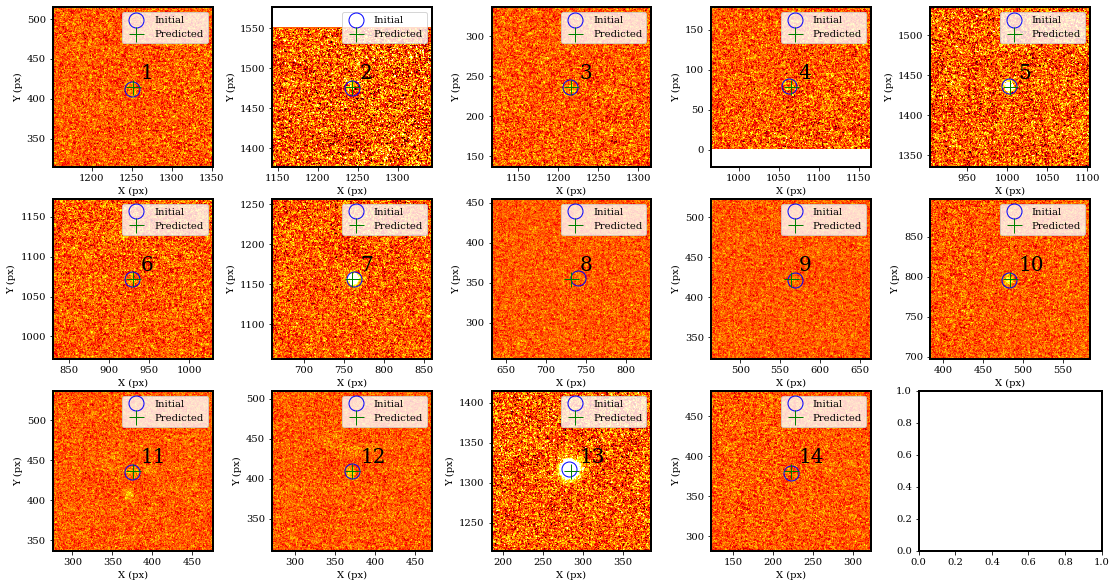

In [14]:
mpl.rcParams['font.size'] = 10

fig, axarr = plt.subplots(ncols=5, nrows=3, figsize=(19, 10))

for i in range(len(df)):
    ax = axarr.flatten()[i]
    jimshow(
        image2d=image2d, 
        ax=ax, 
        aspect='equal',
        xlabel='',
        ylabel='',
        cbar_orientation=None
    )
    xp = df['X'].values[i] + 1
    yp = df['Y'].values[i] + 1
    ax.plot(xp, yp, 'bo', markersize=15, fillstyle='none', label='Initial')
    xp = xpredicted[i] + 1
    yp = ypredicted[i] + 1
    ax.plot(xp, yp, 'g+', markersize=15, fillstyle='none', label='Predicted')
    delta = 100
    ax.text(xp + delta/10, yp + delta/10, str(i+1), fontsize=20)
    ax.set_xlim([xp-delta, xp+delta])
    ax.set_ylim([yp-delta, yp+delta])
    ax.set_xlabel('X (px)', fontsize=10, family='serif')
    ax.set_ylabel('Y (px)', fontsize=10, family='serif')
    ax.legend(loc=1,prop={'family':'serif'})
plt.show()

Likewise, we can convert X and Y to celestial coordinates using the WCS transformation

In [15]:
sky_circe = w.pixel_to_world(df['X'].values, df['Y'].values)

We create an `SkyCoord` object with the sky coordinates obtained from the 3D-HST catalog

In [16]:
c = SkyCoord(df['RA'].values, df['DEC'].values, unit="deg")

We compute the on-sky separation between the initial and the predicted coordinates.

In [17]:
sep = c.separation(sky_circe)
print('Median on-sky separation: ', np.median(sep))

Median on-sky separation:  0d00m00.1586s
